# Unit 2: Q-Learning with FrozenLake-v1 and Taxi-v3

In [3]:
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [4]:
import os
import pickle
import random

import gym
import imageio
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

## Setup

In [25]:
env = gym.make('FrozenLake-v1', map_name='8x8', is_slippery=True)

/home/matt/venv/hfrl/lib/python3.10/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/matt/venv/hfrl/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


**Q-Table initialization**

In [27]:
n_states = env.observation_space.n
n_actions = env.action_space.n
print(f'There are {n_states} states and {n_actions} actions')

There are 64 states and 4 actions


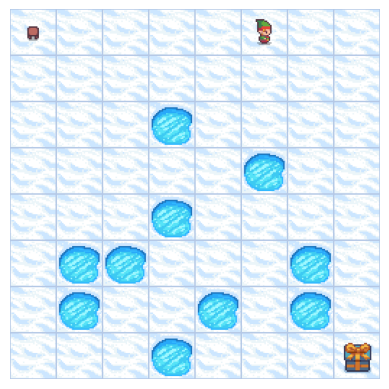

In [39]:
frame = env.render('rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

In [51]:
def initialize_qtable(n_states, n_actions):
    return np.zeros((n_states, n_actions))

In [52]:
qtable_frozenlake = initialize_qtable(n_states, n_actions)

**Greedy policy definition**

In [53]:
def greedy_policy(qtable, state):
    return np.argmax(qtable[state])

**$\epsilon$-greedy policy definition**

In [54]:
def epsilon_greedy_policy(qtable, state, epsilon):
    if random.random() > epsilon:
        return greedy_policy(qtable, state)
    return random.randrange(qtable.shape[1])

**Define hyperparameters**

In [55]:
# Training parameters
n_training_episodes = 500000
learning_rate = lambda x: 0.5 * 0.955 ** int(100 * x)

# Evaluation parameters
n_eval_episodes = 1000

# Environment parameters
env_id = 'FrozenLake-v1'
max_steps = 999
gamma = 0.97
eval_seed = []

# Exploration parameters
max_epsilon = 1
min_epsilon = 0.005
decay_rate = 0.00001

## Training

In [59]:
def rolling_average(arr, w=500):
    ret = np.cumsum(arr)
    ret[w:] = ret[w:] - ret[:-w]
    rolling_avg = ret[w - 1:] / w
    return rolling_avg

def train(
        n_training_episodes,
        learning_rate, 
        min_epsilon, 
        max_epsilon, 
        decay_rate, 
        env, 
        gamma,
        max_steps, 
        qtable):
    total_rewards = []
    hit_max_steps = []
    for episode in tqdm(range(n_training_episodes)):
        total_reward = 0
        dt = episode / (n_training_episodes - 1)
        lr = learning_rate(dt)
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        
        state = env.reset()
        step = 0
        done = False
        hit_max_step = True
        
        for step in range(max_steps):
            action = epsilon_greedy_policy(qtable, state, epsilon)
            
            new_state, reward, done, info = env.step(action)
            total_reward += reward
            
            qtable[state][action] += \
                lr * (reward + gamma * np.max(qtable[new_state]) - qtable[state][action])
            
            if done:
                hit_max_step = False
                break
            
            state = new_state
        
        hit_max_steps.append(hit_max_step)
        total_rewards.append(total_reward)
    
    # Compute a rolling windowed average over 500 episodes at a time
    w = 500
    reward_average = rolling_average(total_rewards, w)
    hit_max_average = rolling_average(hit_max_steps, w)
    
    plt.plot(reward_average)
    plt.plot(hit_max_average, '--')
    plt.xlabel('Episode')
    plt.ylabel(f'{w}-episode average reward')
    plt.title('Average reward during training')
    plt.show()
    return qtable


In [ ]:
qtable_frozenlake = train(
    n_training_episodes,
    learning_rate,
    min_epsilon,
    max_epsilon,
    decay_rate,
    env,
    gamma,
    max_steps,
    qtable_frozenlake)

  0%|          | 0/500000 [00:00<?, ?it/s]

###### **View result**

In [38]:
qtable_frozenlake

array([[5.42012694e-02, 6.06306131e-02, 5.50679963e-02, 5.49556004e-02],
       [5.66164470e-02, 5.60145662e-02, 6.47940951e-02, 5.52637282e-02],
       [6.35045143e-02, 6.68693201e-02, 7.27749589e-02, 6.55322721e-02],
       [6.75213656e-02, 7.68585248e-02, 1.35692611e-01, 7.39357584e-02],
       [8.45802921e-02, 8.38540115e-02, 1.52496546e-01, 8.53155686e-02],
       [9.47925051e-02, 1.55404079e-01, 9.51266185e-02, 9.25116955e-02],
       [1.31193249e-01, 1.10054653e-01, 1.09665445e-01, 1.09739494e-01],
       [1.14389166e-01, 1.15932364e-01, 1.53225823e-01, 1.15849464e-01],
       [5.35197717e-02, 5.31192023e-02, 3.48332819e-02, 5.69587217e-02],
       [5.60885208e-02, 5.62049519e-02, 6.50048676e-02, 5.60889717e-02],
       [5.37890477e-02, 5.44308832e-02, 6.45790856e-02, 7.64097282e-02],
       [1.64018245e-02, 3.91554700e-02, 3.25998137e-02, 8.35282453e-02],
       [7.96032607e-02, 8.05818938e-02, 6.19283320e-02, 9.27882252e-02],
       [1.00753904e-01, 1.21163780e-01, 8.10912779e

## Evaluation

In [40]:
def evaluate_agent(env, max_steps, n_eval_episodes, qtable, seed):
    episode_rewards = []
    for episode in tqdm(range(n_eval_episodes)):
        if seed:
            state = env.reset(seed=seed[episode])
        else:
            state = env.reset()
        
        step = 0
        done = False
        total_rewards_ep = 0
        
        for step in range(max_steps):
            action = greedy_policy(qtable, state)
            new_state, reward, done, info = env.step(action)
            total_rewards_ep += reward
            
            if done:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward

**Evaluate**

In [41]:
mean_reward, std_reward = evaluate_agent(env, max_steps*10, n_eval_episodes, qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean_reward=0.41 +/- 0.49


## Push to Hub

In [42]:
import datetime
import json

from pathlib import Path

from huggingface_hub import HfApi, snapshot_download
from huggingface_hub.repocard import metadata_eval_result, metadata_save

In [43]:
def record_video(env, qtable, out_file, fps=1):
    out_dir = os.path.dirname(out_file)
    os.makedirs(out_dir, exist_ok=True)
    writer = imageio.get_writer(out_file, fps=fps)
    done = False
    state = env.reset()#seed=random.randint(0,500))
    img = env.render(mode='rgb_array')
    writer.append_data(img)
    while not done:
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[state][:])
        state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
        img = env.render(mode='rgb_array')
        writer.append_data(img)

    writer.close()

In [44]:
for i in range(5):
    record_video(env, qtable_frozenlake, f'./media/8x8/slippery/test{i}.mp4', 4)

In [46]:
%%html
<video controls autoplay><source src="./media/8x8/slippery/test3.mp4" type="video/mp4"></video>

In [ ]:
def push_to_hub(
    repo_id, model, env, video_fps=2, local_repo_path="hub"
):
    """
    Evaluate, Generate a video and Upload a model to Hugging Face Hub.
    This method does the complete pipeline:
    - It evaluates the model
    - It generates the model card
    - It generates a replay video of the agent
    - It pushes everything to the Hub

    :param repo_id: repo_id: id of the model repository from the Hugging Face Hub
    :param env
    :param video_fps: how many frame per seconds to record our video replay 
    (with taxi-v3 and frozenlake-v1 we use 1)
    :param local_repo_path: where the local repository is
    """
    _, repo_name = repo_id.split("/")

    eval_env = env
    api = HfApi()

    # Step 1: Create the repo
    repo_url = api.create_repo(
        repo_id=repo_id,
        exist_ok=True,
    )

    # Step 2: Download files
    repo_local_path = Path(snapshot_download(repo_id=repo_id))

    # Step 3: Save the model
    if env.spec.kwargs.get("map_name"):
        model["map_name"] = env.spec.kwargs.get("map_name")
        if env.spec.kwargs.get("is_slippery", "") == False:
            model["slippery"] = False

    # Pickle the model
    with open((repo_local_path) / "q-learning.pkl", "wb") as f:
        pickle.dump(model, f)

    # Step 4: Evaluate the model and build JSON with evaluation metrics
    mean_reward, std_reward = evaluate_agent(
        eval_env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"]
    )

    evaluate_data = {
        "env_id": model["env_id"],
        "mean_reward": mean_reward,
        "n_eval_episodes": model["n_eval_episodes"],
        "eval_datetime": datetime.datetime.now().isoformat()
    }

    # Write a JSON file called "results.json" that will contain the
    # evaluation results
    with open(repo_local_path / "results.json", "w") as outfile:
        json.dump(evaluate_data, outfile)

    # Step 5: Create the model card
    env_name = model["env_id"]
    if env.spec.kwargs.get("map_name"):
        env_name += "-" + env.spec.kwargs.get("map_name")

    if env.spec.kwargs.get("is_slippery", "") == False:
        env_name += "-" + "no_slippery"

    metadata = {}
    metadata["tags"] = [env_name, "q-learning", "reinforcement-learning", "custom-implementation"]

    # Add metrics
    eval = metadata_eval_result(
        model_pretty_name=repo_name,
        task_pretty_name="reinforcement-learning",
        task_id="reinforcement-learning",
        metrics_pretty_name="mean_reward",
        metrics_id="mean_reward",
        metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
        dataset_pretty_name=env_name,
        dataset_id=env_name,
    )

    # Merges both dictionaries
    metadata = {**metadata, **eval}

    model_card = f"""
  # **Q-Learning** Agent playing1 **{env_id}**
  This is a trained model of a **Q-Learning** agent playing **{env_id}** .

  ## Usage

  ```python
  
  model = load_from_hub(repo_id="{repo_id}", filename="q-learning.pkl")

  # Don't forget to check if you need to add additional attributes (is_slippery=False etc)
  env = gym.make(model["env_id"])
  ```
  """

    evaluate_agent(env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])
  
    readme_path = repo_local_path / "README.md"
    readme = ""
    print(readme_path.exists())
    if readme_path.exists():
        with readme_path.open("r", encoding="utf8") as f:
            readme = f.read()
    else:
        readme = model_card

    with readme_path.open("w", encoding="utf-8") as f:
        f.write(readme)

    # Save our metrics to Readme metadata
    metadata_save(readme_path, metadata)

    # Step 6: Record a video
    video_path = repo_local_path / "replay.mp4"
    record_video(env, model["qtable"], video_path, video_fps)

    # Step 7. Push everything to the Hub
    api.upload_folder(
        repo_id=repo_id,
        folder_path=repo_local_path,
        path_in_repo=".",
    )

    print("Your model is pushed to the Hub. You can view your model here: ", repo_url)

**Do the pushing**

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,

    "learning_rate": learning_rate,
    "gamma": gamma,

    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,

    "qtable": qtable_frozenlake
}

In [ ]:
username = "matt-guay"
repo_name = "q-FrozenLake-v1-4x4-Slippery"
push_to_hub(
    repo_id=f"{username}/{repo_name}",
    model=model,
    env=env)

---

#  Taxi-v3

---

**Environment exploration**

In [ ]:
env = gym.make('Taxi-v3')

In [ ]:
n_states = env.observation_space.n
n_actions = env.action_space.n
print(f'There are {n_states} states and {n_actions} actions')

**Q table initialization**

In [ ]:
qtable_taxi = initialize_qtable(n_states, n_actions)

**Hyperparameters**

In [ ]:
# Training parameters
n_training_episodes = 25000
learning_rate = lambda x: 0.7 # * 0.955 ** int(100 * x)

# Evaluation parameters
n_eval_episodes = 100

# Environment parameters
env_id = 'Taxi-v3'
max_steps = 99
gamma = 0.95
eval_seed = [16,54,165,177,191,191,120,80,149,178,48,38,6,125,174,73,50,172,100,148,146,6,25,40,68,148,49,167,9,97,164,176,61,7,54,55,
 161,131,184,51,170,12,120,113,95,126,51,98,36,135,54,82,45,95,89,59,95,124,9,113,58,85,51,134,121,169,105,21,30,11,50,65,12,43,82,145,152,97,106,55,31,85,38,
 112,102,168,123,97,21,83,158,26,80,63,5,81,32,11,28,148]

# Exploration parameters
max_epsilon = 1
min_epsilon = 0.001
decay_rate = 0.004

**Train**

In [ ]:
qtable_taxi = train(
    n_training_episodes,
    learning_rate,
    min_epsilon,
    max_epsilon,
    decay_rate,
    env,
    gamma,
    max_steps,
    qtable_taxi)

In [ ]:
for i in range(5):
    record_video(env, qtable_taxi, f'./media/taxi/test{i}.mp4', 4)

In [ ]:
%%html
<video controls autoplay><source src="./media/taxi/test1.mp4" type="video/mp4"></video>

**Push to Hub**

In [ ]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,

    "learning_rate": 0.7,
    "gamma": gamma,

    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,

    "qtable": qtable_taxi
}

In [ ]:
username = "matt-guay"
repo_name = "q-Taxi-v3"
push_to_hub(
    repo_id=f"{username}/{repo_name}",
    model=model,
    env=env)